# T1 estimation MFIR method [1]

The general formulation for the T1 estimation using the modified fast inversion-recovery method [1] is given by:  

$$ S(T_I) = S_0\biggl(1 - (1 - k_1)\exp(-T_I/T_1) - k_2 \exp(-(T_R - NTE)/T_1) \biggr) $$

This model has 4 inputs:
* $T_I$:Preparation Time (Inversion Time in our case, but can also be the Saturation time)  
* $T_R$: Repetition time (i.e. time between successive inversion or preparation pulses)
* $NTE$: Duration of the echo train or readout time in the case of a single-shot sequence ($=N*TE$)
* C:  a flag (i.e. binary variable) to include or exclude the effect of the echoes in the $T_1$ function (see model in the next subsection)  

And up to 4 parameters [] that can be optimised:  
* $T_1$
* $S_0$
* $k_1$ (or $\phi$, as shown below)
* $k_2$

Depending on how many of these parameters are varied through the fitting, there are at least three possibilities we have to explore:
* Two parameters fit
    * $S_0$ and $T_1$ are the optimisation variables, any other parameter is fixed
* Three parameters fit
    * $S_0$, $T_1$, $k_1$ are the optimisation variables, any other parameter is fixed
* Four parameters fit:
    * $S_0$, $T_1$, $k_1$, $k_2$ are the optimisation variables.

According to [1], $k_1$ is defined as _the ratio of longitudinal magnetisation after the inversion to the longitudinal magnetisation before the inversion_ (i.e. $M_z/M_0$), which is equivalent to $\cos(\theta_{INV})$, with $\theta_{INV}$ the inversion angle (e.g. $\theta_{INV}=180^{\text{o}}$ for an Inversion Recovery sequence and $\theta_{INV}=90^{\text{o}}$ for a Saturation Recovery sequence).

$$ 1-k_1 = 1 - \cos(\theta_{INV}) $$

For the particular case of an Inversion Recovery method, where the expected ratio is $-1$, we have worked it in terms of the inversion efficiency, $\phi$. Both formulation are equivalent, but they may have impact on the dynamic range of each parameter (see next section).  

The additional parameter $k_2$ compensates any imperfection in the echo train length (e.g. imperfect refocusing pulse, inhomogeities), while $k_1$ compensates imperfect inversion (or saturation) in the preparation pulse(s). Both terms are related as $k_2$ is $k_1$ multiplied by a correction factor.  
* With perfect pulses, $k_1 = -1$ (i.e. $M_z/M_0=-1$, equivalently, $\theta_{INV} = 180^{\text{o}}$).  
* With no echoes, $k_1 = k_2$ Because no other RF pulse are applied, then only $k_1$ affects the recovery.  

Considering these assumptions, the signal equation for the ideal case with no echoes becomes:  
$$ S(T_I) = S_0\biggl(1 - (1 - k_1)\exp(-T_I/T_1) - k_1 \exp(-T_R/T_1) \biggr)$$
**which suggests the TR is not the whole acquisition time, but is indeed the difference between the time between inversions and the inversion time...**

Let see the timing diagram of a single slice HASTE:
<img src="HASTE-diagram/Slide1.png">  

**What is reported in the DICOM header is $TR_{ACQ}$, rather than $T_R$, suggesting we'll have to consider $T_R = TR_{ACQ}-T_{I}$????**  

# $k_1$ or $\phi$??  
Focusing only in the inversion recovery method, we can assume the term $1-k_1 = 2$ in the ideal case, if perfect pulses. Alternatively, if imperfect or not full inversions (i.e. $\theta_{INV}<180^{\text{o}}$), then we add the inversion efficiency term, $\phi$ so the relationship becomes $1-k_1 = 2\phi$. The relationship between $k_1$, $k_2$ and $\phi$ can then be summarised as:
* $1-k_1 = 2\phi$  
* $k_1 \propto k_2 \rightarrow k_2 \propto 1-2\phi$

We can see from them, that $\phi\in [0,1]$, therefore $k_1 \in [-1, 1]$.  However, in [1] there is no constraints mentioned for $k_2$, apart that it is proportional to $k_1$. So in principle, $k_2 \in ]-\infty, \infty[$.  
** _Is this correct???_ **

***************************

## How does $\phi$ relates to $\theta_{INV}$?
$1-k_1=2\phi=1-\cos(\theta_{INV}) \rightarrow \theta_{inv} = \arccos(1-2\phi)$  

Example:  
For an inversion efficiency of $80\%$ ($\phi = 0.8 $), it is equivalent to have an inversion angle of $127^{\text{o}}$

## Reference
[1] P. Kingsley et al; MRI 19:279-282; 2001, 


# Fitting functions

In [1]:
%matplotlib inline
""" t1_fit_funcs.py
"""

import math
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm

from lmfit import minimize, Parameters


def t1_func(s0, t1, ti, tr, nte, f=1.0, k2=-1.0, C=1):
    return s0*(1-2 * f * math.exp(-(ti/t1)) - C * k2 * math.exp(-(tr-nte)/t1))

def fit_t1(params, t, values):
    s0 = params['s0'].value
    t1 = params['t1'].value
    tr = params['tr'].value
    nte = params['nte'].value
    c = params['c'].value
    f = params['f'].value
    f2 = params['f2'].value

    signal = [t1_func(s0, t1, x, tr-x, nte, f, f2, c) for x in t]
    return (np.fabs(signal) - np.fabs(values))

def do_2p_fit(ydata, it, tr, nte, initial_s0=1.0, initial_t1=1000.0, phi=1.0, k2=-1.0):

    params = Parameters()
    params.add('s0',  value=initial_s0, vary=True)
    params.add('t1',  value=initial_t1, vary=True, min=0.0, max=5000.0)

    params.add('tr',  value=tr,         vary=False)
    params.add('nte', value=nte,        vary=False)
    params.add('c',   value=1.0,        vary=False)
    params.add('f',   value=phi,        vary=False)
    params.add('f2',  value=k2,       vary=False)

    result = minimize(fit_t1, params, args=(it, ydata))

    return result

def do_3p_fit(ydata, it, tr, nte, initial_s0=1.0, initial_t1=1000.0, phi=1.0, k2=-1.0):

    params = Parameters()
    params.add('s0',  value=initial_s0, vary=True)
    params.add('t1',  value=initial_t1, vary=True, min=0.0, max=5000.0)
    params.add('f',   value=phi,        vary=True, min=0.0, max=1.8)

    params.add('tr',  value=tr,         vary=False)
    params.add('nte', value=nte,        vary=False)
    params.add('c',   value=1.0,        vary=False)
    params.add('f2',  value=k2,         vary=False)

    result = minimize(fit_t1, params, args=(it, ydata))

    return result

def do_4p_fit(ydata, it, tr, nte, initial_s0=1.0, initial_t1=1000.0, phi=1.0, k2=-1.0):

    params = Parameters()
    params.add('s0',  value=initial_s0, vary=True)
    params.add('t1',  value=initial_t1, vary=True, min=0.0, max=5000.0)
    params.add('f',   value=phi,        vary=True, min=0.0, max=1.8)
    params.add('f2',  value=k2,         vary=True,  min=-1.0, max=1.0)

    params.add('tr',  value=tr,         vary=False)
    params.add('nte', value=nte,        vary=False)
    params.add('c',   value=1.0,        vary=False)

    result = minimize(fit_t1, params, args=(it, ydata))

    return result



/home/vagrant/.local/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Example parameters:

In [2]:
# Parameters of the sample:
T1tissue  = 1000.0
S0tissue  = 1.0

# Parameters of the scanner/sequence:
INVeffIdeal = 1.0
#With no echoes, k2=k1 ==> k2 = 1-2PHI = -1, but in our case, there are ETL echoes, so what should be the ideal value??
K2ideal = -1.0

# Parameters of the acquisition:
TRacq  = 6000.0
TEacq  = 3.85
ETLacq = 68
FAacq  = 90.0

# Inversion times:
nreps   = 5
TIlist  = np.array([22.0, 50.0, 300.0, 1100.0, 2000.0, 5000.0])
TImeas  = np.repeat(TIlist, nreps)

# For display purposes, generate a densely sampled curve:
ntc = 1024
maxTI = np.max(TIlist)
TIcontinuous = np.linspace(0.0, maxTI, ntc)


# $T_R$ or $TR_{ACQ}$??

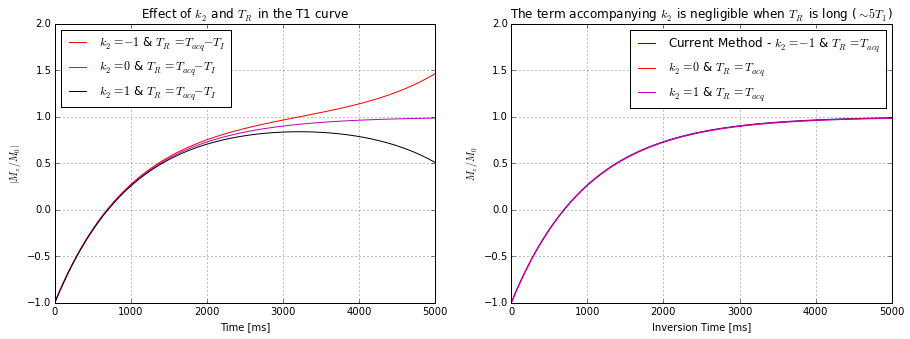

In [3]:
C = 1 # I'm using echoes
# How we do it currently (i.e. TR=Tacq) and K2 = K1 = -1.0, somehow it is contradictory, 
# because K1=K2 happens when there are no echoes
T1currMeth = [t1_func(S0tissue, T1tissue, tival, TRacq, ETLacq*TEacq, INVeffIdeal, K2ideal, C) for tival in TIcontinuous]

# k2 = 0.0 & TR=Tacq:
T1k20_TRTacq = [t1_func(S0tissue, T1tissue, tival, TRacq, ETLacq*TEacq, INVeffIdeal, 0.0, C) for tival in TIcontinuous]

# k2 = 1.0 & TR=Tacq:
T1k2p1_TRTacq = [t1_func(S0tissue, T1tissue, tival, TRacq, ETLacq*TEacq, INVeffIdeal, 1.0, C) for tival in TIcontinuous]


# k2 = -1.0 & TR=Tacq-TI:
T1k2m1_TRTacqmTI = [t1_func(S0tissue, T1tissue, tival, TRacq-tival, ETLacq*TEacq, INVeffIdeal, K2ideal, C) for tival in TIcontinuous]

# k2 = 1.0 & TR=Tacq-TI:
T1k2p1_TRTacqminusTI = [t1_func(S0tissue, T1tissue, tival, TRacq-tival, ETLacq*TEacq, INVeffIdeal, 1.0, C) for tival in TIcontinuous]

# k2 = 0.0 & TR=Tacq-TI:
T1k20_TRTacqminusTI = [t1_func(S0tissue, T1tissue, tival, TRacq-tival, ETLacq*TEacq, INVeffIdeal, 0.0, C) for tival in TIcontinuous]

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax1.plot(TIcontinuous, (T1k2m1_TRTacqmTI),'r-', label='$k_2=-1$ & $T_R=T_{acq}-T_I$')
ax1.plot(TIcontinuous, (T1k20_TRTacqminusTI),'m-', label='$k_2=0$ & $T_R=T_{acq}-T_I$')
ax1.plot(TIcontinuous, (T1k2p1_TRTacqminusTI),'k-', label='$k_2=1$ & $T_R=T_{acq}-T_I$')
ax1.grid()
ax1.axis([0.0, maxTI, -1.0*S0tissue, 2.0*S0tissue])
plt.xlabel('Time [ms]')
plt.ylabel('$\|M_z/M_0\|$')
ax1.legend(loc='best')
plt.title('Effect of $k_2$ and $T_R$ in the T1 curve')

ax2 = fig.add_subplot(122)
ax2.plot(TIcontinuous, (T1currMeth),'b-', label='Current Method - $k_2=-1$ & $T_R=T_{acq}$')
ax2.plot(TIcontinuous, (T1k20_TRTacq),'r-', label='$k_2=0$ & $T_R=T_{acq}$')
ax2.plot(TIcontinuous, (T1k2p1_TRTacq),'m-', label='$k_2=1$ & $T_R=T_{acq}$')
ax2.grid()
ax2.axis([0.0, maxTI, -1.0*S0tissue, 2.0*S0tissue])
plt.xlabel('Inversion Time [ms]')
plt.ylabel('$M_z/M_0$')
ax2.legend(loc='best')
plt.title('The term accompanying $k_2$ is negligible when $T_R$ is long ($\sim 5T_1$)')


## Were we calculating it wrong? or for the parameters used there are minimum differences??

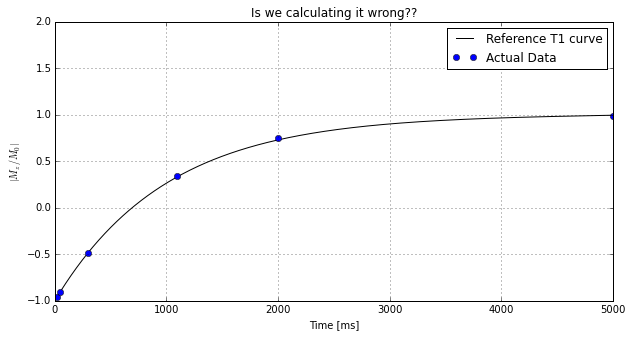

In [4]:
# Ideal Curve:
phi = 1.0; k2 = -1.0 ; idealTr = 10000.0
T1Ref = [t1_func(S0tissue, T1tissue, tival, idealTr-tival, ETLacq*TEacq, phi, k2, C=1.0) for tival in TIcontinuous]

TRlist = [15000.0, 15000.0, 15016.0, 6076.0, 6080.0, 13080.0]
T1Real = [t1_func(S0tissue, T1tissue, tival, tr-tival, ETLacq*TEacq, phi, k2, C=1.0) for tival, tr in zip(TIlist, TRlist)]

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(111)
ax1.plot(TIcontinuous, (T1Ref),'k-', label='Reference T1 curve')
ax1.plot(TIlist, (T1Real),'bo', label='Actual Data')
ax1.grid()
ax1.axis([0.0, maxTI, -1.0*S0tissue, 2.0*S0tissue])
plt.xlabel('Time [ms]')
plt.ylabel('$\|M_z/M_0\|$')
ax1.legend(loc='best')
plt.title('Is we calculating it wrong??')


The shape of the curve depend on the TR of the acquisition. As expected, the longer the TR, the less sensitive at the end of the curve.  
Note that this method is intended to cope with shorter TR!!! (see original reference Gupta et al. A modified fast inversion-recovery technique for spin-lattice relaxation measurement. JMR 38:447-452; 1980)  

It seems also that we can establish the validity range of $k_2$ by looking at the graph to the left. 
Similarly, by looking at the graph to the right, the effect of $k_2$ is negligible when $T_R$ is long ($~T_{acq}$), as expected.  

**But the question is, what's the value of $k_2$ in ideal condition with $N$ echoes? **

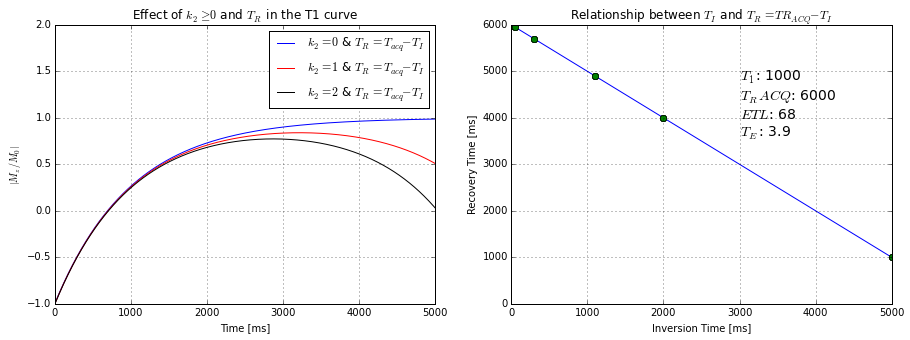

In [5]:
# k2 = 2.0 & TR=Tacq-TI:
T1k2p2_TRTacqminusTI = [t1_func(S0tissue, T1tissue, tival, TRacq-tival, ETLacq*TEacq, INVeffIdeal, 2.0, C) for tival in TIcontinuous]

fig = plt.figure(figsize = (15,5))
ax  = fig.add_subplot(121)
ax.plot(TIcontinuous, (T1k20_TRTacqminusTI),'b-', label='$k_2=0$ & $T_R=T_{acq}-T_I$')
ax.plot(TIcontinuous, (T1k2p1_TRTacqminusTI),'r-', label='$k_2=1$ & $T_R=T_{acq}-T_I$')
ax.plot(TIcontinuous, (T1k2p2_TRTacqminusTI),'k-', label='$k_2=2$ & $T_R=T_{acq}-T_I$')


ax.grid()
ax.axis([0.0, maxTI, -1.0*S0tissue, 2.0*S0tissue])
plt.xlabel('Time [ms]')
plt.ylabel('$\|M_z/M_0\|$')
ax.legend(loc='best')
plt.title('Effect of $k_2 \geq 0$ and $T_R$ in the T1 curve')


ax = fig.add_subplot(122)
ax.plot(TIcontinuous, TRacq-TIcontinuous)
ax.plot(TImeas, TRacq-TImeas,'o')
ax.grid()
plt.xlabel('Inversion Time [ms]')
plt.ylabel('Recovery Time [ms]')
ax.axis([0.0, maxTI, 0.0, TRacq])
ax.text(0.6*maxTI, 0.6*TRacq,'$T_1$: {:.0f}\n$T_RACQ$: {:.0f}\n$ETL$: {:.0f}\n$T_E$: {:.2}'.format(T1tissue,
                                                                                                TRacq,
                                                                                                ETLacq,
                                                                                                TEacq),
        fontsize=14)
plt.title('Relationship between $T_I$ and $T_R=TR_{ACQ}-T_I$')


# Use this to monkey with the parameters:

[0.0, 5000.0, -1.5, 1.5]

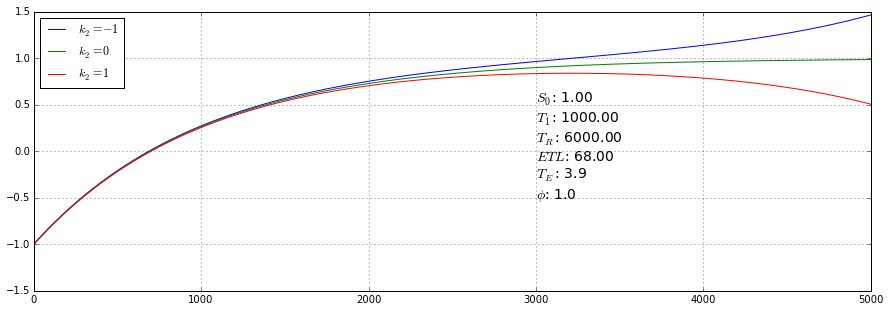

In [6]:
# Monkey curve:
S0=1.0; T1=1000.0; TR = 6000.0; ETL=68; TE=3.9; PHI=1.0; K2=-1.0
T1monkeyMINUS = [t1_func(S0, T1, tival, TR-tival, ETL*TE, C, PHI, K2) for tival in TIcontinuous]
T1monkeyZERO  = [t1_func(S0, T1, tival, TR-tival, ETL*TE, C, PHI, 0.0*K2) for tival in TIcontinuous]
T1monkeyPLUS  = [t1_func(S0, T1, tival, TR-tival, ETL*TE, C, PHI, -1.0*K2) for tival in TIcontinuous]


fig = plt.figure(figsize = (15,5))
ax  = fig.add_subplot(111)
ax.plot(TIcontinuous, (T1monkeyMINUS))
ax.plot(TIcontinuous, (T1monkeyZERO))
ax.plot(TIcontinuous, (T1monkeyPLUS))

plt.legend(['$k_2=-1$', '$k_2=0$', '$k_2=1$'], loc='best')

plt.grid()
plt.text(0.6*maxTI, -0.5*S0, 
         '$S_0$: {:.2f}\n$T_1$: {:.2f}\n$T_R$: {:.2f}\n$ETL$: {:.2f}\n$T_E$: {:.2}\n$\phi$: {:.2}'.format(S0,
                                                                                         T1, 
                                                                                         TR,
                                                                                         ETL,
                                                                                         TE,
                                                                                         PHI), 
         fontsize=14)
ax.axis([0.0, maxTI, -1.5*S0, 1.5*S0])





# Proper simulation of T1 estimation using all 2, 3 and/or 4 parameters

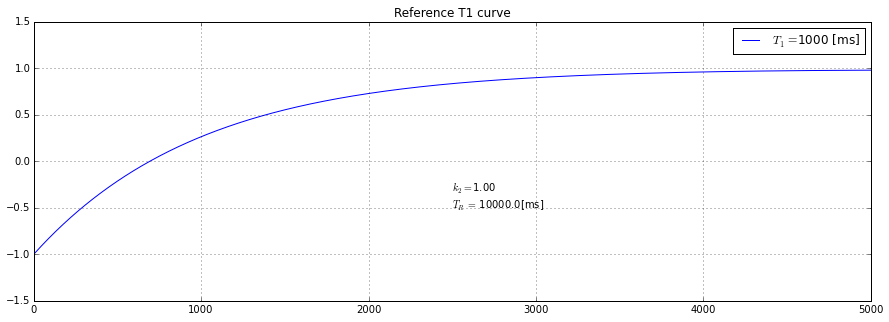

In [7]:
T1tissue  = 1000.0
S0tissue  = 1.0
PHI       = 1.0
K2        = 1.0
TRacq     = 10000.0
TE        = 3.85
ETL       = 0
FA        = 90.0

nreps     = 5
TIlist    = np.array([22.0, 50.0, 300.0, 1100.0, 2000.0, 5000.0])
TImeas    = np.repeat(TIlist, nreps)

ntc          = 1024
maxTI        = np.max(TIlist)
TIcontinuous = np.linspace(0.0, maxTI, ntc)


T1ReferenceCurve = [t1_func(S0tissue, T1tissue, tival, TRacq-tival, ETL*TE, PHI, K2, C) for tival in TIcontinuous]
fig = plt.figure(figsize = (15,5))
ax  = fig.add_subplot(111)
ax.plot(TIcontinuous, (T1ReferenceCurve))
plt.grid()
plt.title('Reference T1 curve')
plt.legend(['$T_1 = ${:.0f} [ms]'.format(T1tissue)])
plt.axis([0.0, np.max(TIcontinuous), -1.5*S0tissue, 1.5*S0tissue])
plt.text(0.5*np.max(TIcontinuous), -0.5*S0tissue, '$k_2 = ${:.2f} \n$T_R = $ {:.1f}[ms]'.format(K2,TRacq))


In [8]:
PHI = 0.82 # THETA_{INV} = 180deg
TRacq  = 6000.0

# Simulate the ideal signal affected only by the acquisition parameters:
SampledT1 = [t1_func(S0tissue, T1tissue, tival, TRacq-tival, ETLacq*TEacq, PHI, 0.0, C) for tival in TImeas]

# Add white noise to the sampled data, this represents the noise independent of any acquisition parameter(i.e. thermal noise):
WofN  = S0tissue * 0.25 # Scale of the noise expressed as a fraction of S0
noise = (np.random.rand(TImeas.size) - 0.5) * WofN

# Simulate the signal measured in "ideal" conditions (i.e. only affected by white noise):
MeasuredT1 = SampledT1 + noise

# Now fit the data and compare the results:
xopt        = do_3p_fit(MeasuredT1, TImeas, TRacq, ETLacq*TEacq, 
                        np.max(MeasuredT1), 1000.0, 1.0, 0.0)
RecoveredT1 = [t1_func(xopt.params['s0'].value, xopt.params['t1'].value, tival, TRacq-tival, ETLacq*TEacq, xopt.params['f'].value, xopt.params['f2'].value, C) for tival in TIcontinuous]


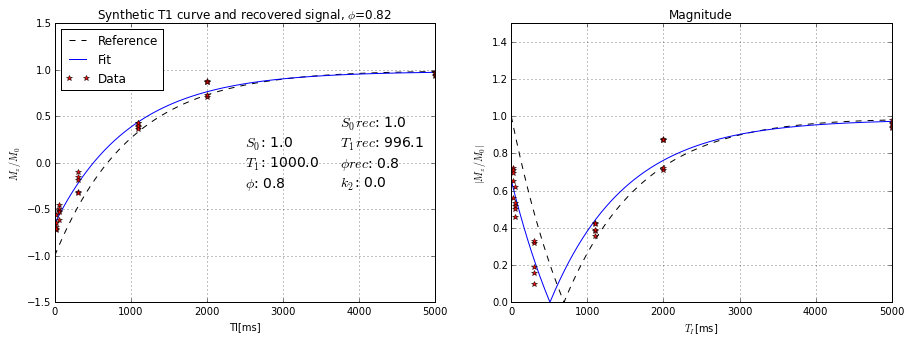

In [9]:
fig   = plt.figure(figsize = (15,5))
ax    = fig.add_subplot(121)
plt.plot(TIcontinuous, (T1ReferenceCurve),'k--')
plt.plot(TIcontinuous, (RecoveredT1),'b-')
plt.plot(TImeas, (MeasuredT1),'r*')
plt.grid()
plt.axis([TIcontinuous[0], TIcontinuous[-1], -1.5*S0tissue, 1.5*S0tissue])
plt.text(0.5*TIcontinuous[-1], -0.25*S0tissue, 
         '$S_0$: {:.1f}\n$T_1$: {:.1f}\n$\phi$: {:.1f}'.format(S0tissue, 
                                                      T1tissue, 
                                                      PHI), 
         fontsize=14)    

plt.text(0.75*TIcontinuous[-1], -0.25*S0tissue, 
         '$S_0rec$: {:.1f}\n$T_1rec$: {:.1f}\n$\phi rec$: {:.1f}\n$k_2$: {:.1f}'.format(xopt.params['s0'].value, 
                                                                                xopt.params['t1'].value, 
                                                                                xopt.params['f'].value,
                                                                                xopt.params['f2'].value), 
         fontsize=14)
plt.title('Synthetic T1 curve and recovered signal, $\phi$='+str(PHI))
plt.xlabel('TI[ms]')
plt.ylabel('$M_z/M_0$')
plt.legend(['Reference', 'Fit', 'Data'], loc='best')

ax    = fig.add_subplot(122)
plt.plot(TIcontinuous, np.fabs(T1ReferenceCurve),'k--')
plt.plot(TIcontinuous, np.fabs(RecoveredT1),'b-')
plt.plot(TImeas, np.fabs(MeasuredT1),'r*')
plt.grid()
plt.axis([TIcontinuous[0],TIcontinuous[-1], 0.0*S0tissue, 1.5*S0tissue])
plt.title('Magnitude')
plt.xlabel('$T_I$[ms]')
plt.ylabel('$\|M_z/M_0\|$')


# Recover the T1 parameters -  Simulate white noise

Understand the effect of noise dependent on the inversion time. We believe this is equivalent to the effect of setting the gain for each acquisition (i.e. each TI), as each of them is repeated n-times ($nreps$), the bias introduced will be the same for each group. In this section, I'll try to simulate this effect...

* Return the parameters to the ideal case and re-sample the T1 curve:

In [10]:
S0tissue = 1.0 ; T1tissue = 1000.0; TRacq = 6000.0; PHI = 1.0 ; K2 = 0.0
ETL = 68 ; TE = 3.9

T1ReferenceCurve = [t1_func(S0tissue, T1tissue, tival, TRacq-tival, ETL*TE, PHI, K2) for tival in TIcontinuous]

SampledT1 = [t1_func(S0tissue, T1tissue, tival, TRacq, ETL*TE, PHI, K2, C) for tival in TImeas]


* Define the noise levels according to the TIs:
$$ \text{Noise}(TI_{unique}) = rand() \\
\text{Noise}(TI) = \text{Noise}(TI_{unique}) * (rand() - 0.5) $$

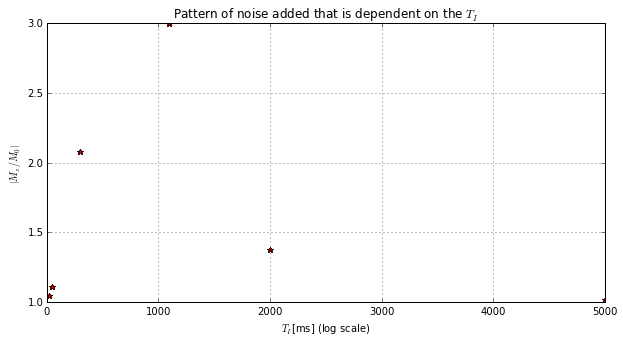

In [11]:
en_scale = 1/(np.fabs([t1_func(S0tissue, T1tissue, tival, TRacq-tival, ETL*TE, PHI, K2) for tival in TIlist]))
en  = en_scale # * np.random.rand(TIlist.size)
# Set a weighting factor for each TI (start with a uniform weight):
WofN  = np.ones_like(en)
enoise = np.repeat(WofN*en, 5)
noise  = enoise #* (np.random.rand(enoise.size)-0.5)

# Display the noise distribution, it should be the same for each TI...
fig = plt.figure(figsize = (10,5))
ax  = fig.add_subplot(111)
# plt.semilogx(TImeas, noise,'r*')
plt.plot(TImeas, noise, 'r*')

plt.grid()
plt.title('Pattern of noise added that is dependent on the $T_I$')
plt.xlabel('$T_I$[ms] (log scale)')
plt.ylabel('$\|M_z/M_0\|$')


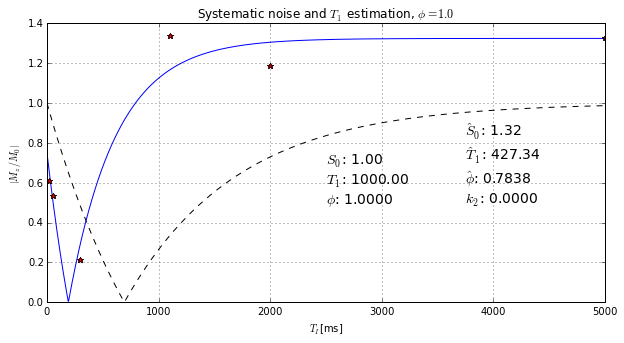

In [12]:
# Add the noise to the sampled data:
MeasuredT1 = SampledT1 + noise / np.max(noise)

# Now fit the data and compare the results:
xopt        = do_3p_fit(ydata=MeasuredT1, it=TImeas, tr=TRacq, nte=ETLacq*TEacq, 
                        initial_s0=np.max(MeasuredT1), initial_t1=1000.0, phi=1.0, k2=0.0)
RecoveredT1 = [t1_func(xopt.params['s0'].value, xopt.params['t1'].value, tival, TRacq-tival, ETLacq * TEacq, xopt.params['f'].value, xopt.params['f2'].value, C) for tival in TIcontinuous]

# And plot the results:
fig = plt.figure(figsize = (10,5))
ax  = fig.add_subplot(111)
plt.plot(TIcontinuous, np.fabs(T1ReferenceCurve),'k--')
plt.plot(TIcontinuous, np.fabs(RecoveredT1),'b-')
plt.plot(TImeas, np.fabs(MeasuredT1),'r*')
plt.grid()
# plt.axis([TIcontinuous[0],TIcontinuous[-1], 0.0*S0tissue, 1.5*S0tissue])
plt.text(0.5*maxTI, 0.5*S0tissue, 
         '$S_0$: {:.2f}\n$T_1$: {:.2f}\n$\phi$: {:.4f}'.format(S0tissue, 
                                                      T1tissue, 
                                                      PHI), 
         fontsize=14)    

plt.text(0.75*maxTI, 0.5*S0tissue, 
         '$\hat S_0$: {:.2f}\n$\hat T_1$: {:.2f}\n$\hat \phi$: {:.4f}\n$k_2$: {:.4f}'.format(xopt.params['s0'].value, 
                                                                              xopt.params['t1'].value, 
                                                                              xopt.params['f'].value,
                                                                              xopt.params['f2'].value), 
         fontsize=14)
plt.title('Systematic noise and $T_1$ estimation, $\phi='+str(PHI)+'$')
plt.xlabel('$T_I$[ms]')
plt.ylabel('$\|M_z/M_0\|$')


# Inverse problem - Recover the signal scale from an expected T1 value
Now it becomes interesting:
* Define a T1 value for the tissue of interest (e.g. muscle ~1000ms)
* Derive the scaling factor for each sample point that is required to obtain the expected T1
* Apply the same scaling factor to other voxels to correct their particular T1

In [13]:
# True signal:
S0tissue = 1.0 ; T1tissue = 1000.0; PHI = 1.0 ; K2 = 0.0
TRacq = 6000.0; ETL = 68 ; TE = 3.9

T1ReferenceCurve = [t1_func(S0tissue, T1tissue, tival, TRacq-tival, ETL*TE, PHI, K2, C) for tival in TIcontinuous]

T1TrueSampled = [t1_func(S0tissue, T1tissue, tival, TRacq-tival, ETL*TE, PHI, K2, C) for tival in TImeas]


In [14]:
# Prior knowledge
S0exp = 1.0; T1exp = 900.0;  PHIexp = 1.0; K2exp = 0.0

T1expected = [t1_func(S0exp, T1exp, tival, TRacq-tival, ETLacq * TEacq, PHIexp, K2exp) for tival in TImeas]

T1ecurve = [t1_func(S0exp, T1exp, tival, TRacq-tival, ETLacq * TEacq, PHIexp, K2exp) for tival in TIcontinuous]


Estimate the scaling factors $a(T_I)$ from the signal measured and the hypothesised curve:
$$ a(T_I) = \frac{S(T_I)}{\hat S(T_I)} $$  
with:  
$\hat S(T_I)$ = Measured from MRI data  
$S(T_I)$ = derived from the signal equation assuming ideal conditions (i.e. Defined $T_1$, $\phi$=1 and $k_2$=-1)

In [15]:
# Masured from MRI is T1TrueSampled + noise:
# noise is made of white noise and TX gain offset
# TX gain is most probably dependant on the signal intensity (i.e. lower signal --> higher gain), 
# but as a starting point, just assume it be random for each TI:
# Tx_scale = np.random.rand(TIlist.size)
# An alternative, based on real data, is a pattern that follows the signal amplitude (mmagnitude):
Tx_scale = [t1_func(1.0, T1tissue, tival, TRacq-tival, ETL*TE, f=1.0, k2=0.0, C=1) for tival in TIlist]
# Repeat the same scale for all the repeats at each TI
offset  = np.repeat(Tx_scale , nreps)
# Add white noise independent for each measurement, this is a fraction of the maximum signal intensity, e.g. 10%:
wnoise  = 1.0*S0tissue * (np.random.rand(TImeas.size) - 0.5)
# Noise is then the sum of the offset and white noise:
noise  = offset + wnoise
# And noise is additive to the signal:
T1Measured = T1TrueSampled + noise

a = T1expected / T1Measured

Srecovered = a*T1Measured
xrecovered = do_3p_fit(Srecovered, TImeas, TRacq, ETL*TE, 
                       initial_s0=np.max(Srecovered), initial_t1=T1exp, phi=1.0, k2=0.0)

xstd = do_3p_fit(T1Measured, TImeas, TRacq, ETL*TE, 
                       initial_s0=np.max(Srecovered), initial_t1=T1exp, phi=1.0, k2=0.0)


T1RecCurve = [t1_func(xrecovered.params['s0'].value, 
                      xrecovered.params['t1'].value,
                      tival, TRacq, ETL * TE, 
                      xrecovered.params['f'].value,
                      xrecovered.params['f2'].value,
                      C) for tival in TIcontinuous]

T1RecStd = [t1_func(xstd.params['s0'].value, 
                      xstd.params['t1'].value,
                      tival, TRacq, ETL * TE, 
                      xstd.params['f'].value,
                      xstd.params['f2'].value,
                      C) for tival in TIcontinuous]


[0.0, 6000.0, 0.0, 0.92597378739933178]

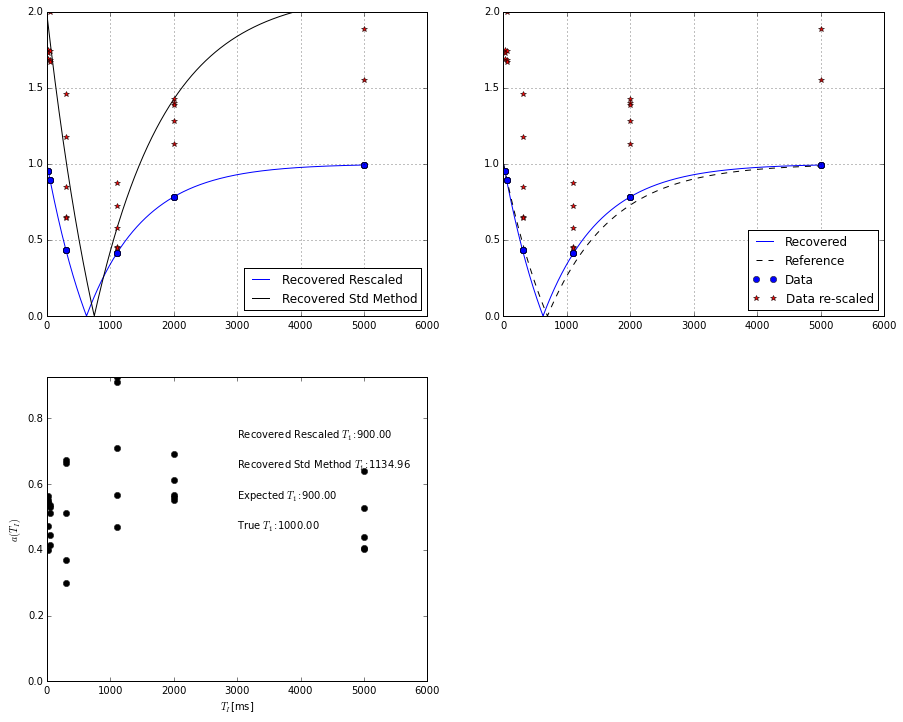

In [16]:
fig = plt.figure(figsize = (15,12))
ax  = fig.add_subplot(221)
plt.plot(TIcontinuous, np.fabs(T1RecCurve),'b-')
plt.plot(TIcontinuous, np.fabs(T1RecStd),'k-')
plt.plot(TImeas, np.fabs(Srecovered),'bo')
plt.plot(TImeas, np.fabs(T1Measured),'r*')
plt.legend(['Recovered Rescaled','Recovered Std Method'], loc='best')
plt.grid()
plt.axis([0.0, 1.2*maxTI, 0.0*S0tissue, 2.0*S0tissue])

ax1  = fig.add_subplot(222)
plt.plot(TIcontinuous, np.fabs(T1RecCurve),'b-')
plt.plot(TIcontinuous, np.fabs(T1ReferenceCurve),'k--')
plt.plot(TImeas, np.fabs(Srecovered),'bo')
plt.plot(TImeas, np.fabs(T1Measured),'r*')
plt.legend(['Recovered','Reference', 'Data', 'Data re-scaled'], loc='best')
plt.grid()
plt.axis([0.0, 1.2*maxTI, 0.0*S0tissue, 2.0*S0tissue])

ax2  = fig.add_subplot(223)
plt.plot(TImeas, a,'ko')
plt.xlabel('$T_I$[ms]')
plt.ylabel('$a(T_I)$')

plt.text(0.6*maxTI, 0.8*np.max(a),'Recovered Rescaled $T_1$:{:.2f}'.format(xrecovered.params['t1'].value))
plt.text(0.6*maxTI, 0.7*np.max(a),'Recovered Std Method $T_1$:{:.2f}'.format(xstd.params['t1'].value))
plt.text(0.6*maxTI, 0.6*np.max(a),'Expected $T_1$:{:.2f}'.format(T1exp))
plt.text(0.6*maxTI, 0.5*np.max(a),'True $T_1$:{:.2f}'.format(T1tissue))
plt.axis([0.0, 1.2*maxTI, 0.0, np.max(a)])






